# Tricky Functions and Cautionary Tales, Continued

In the previous tutorial, we talked about discontinuities (functions that aren't $C_1$-continuous) as a common source of optimization problems.

Let's talk about another: NaNs.

NaNs are a familiar and terrifying sight to any battle-hardened computationalist.

What's a NaN? It's the value that gets returned whenever a function gets evaluated anywhere outside of its domain. When do NaNs tend to appear? Several functions are common culprits:

1. $\sqrt x$ if $x < 0$. (Note: `aerosandbox.numpy` will evaluate this fine, but it can't trace automatic derivatives through complex math, so don't use this in optimization and try to avoid it in general.)

2. More generally, any $x^y$ where $y$ is non-integer and $x < 0$.

3. $\ln x$ or $\log x$ evaluated at $x < 0$.

4. Infinities in either a function's value or its derivative.

The problem with NaNs in optimization is twofold:

1. We can't get a value for the objective function or constraint that is returning the NaN, so we don't know "how good we're doing".

2. We can't get a gradient of the NaN-returning function, so we don't know which direction to look in order to return to the well-posed space.

So, stay away from NaNs! This may seem easy, but it's much easier to introduce NaNs than one might imagine. Let's look at some examples:

## Example 1: Unconstrained $\sqrt x$ Minimization

Let's start with an example that should obviously fail. We're going to try minimizing $\sqrt x$, starting with an initial guess of $x = -1$. Because our initial point will return a NaN, this will obviously fail to solve:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

opti = asb.Opti()

x = opti.variable(init_guess=-1)

opti.minimize(np.sqrt(x))

try:
    sol = opti.solve()
except RuntimeError as e:
    print(e)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Error evaluating objective gradient at user provided starting point.
  No scaling factor for objective function computed!
Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 0

Number

CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]


As expected, this failed, reporting that "Invalid number in NLP (NonLinear Program) function or derivative detected".

## Adding a Non-NaN Initial Guess and Constraint

Okay, so what could we do better? Well, let's make two changes:

1. Let's start from an initial guess of $x=1$, which will return a non-NaN value.
2. Let's implement a constraint $x > 0$, which should keep the function $\sqrt x$ from going into NaN territory.

Now, this optimization problem should be well-posed, right?

In [2]:
opti = asb.Opti()

x = opti.variable(init_guess=1,
                  lower_bound=0)  # `lower_bound` is a shorthand for writing a bounds constraint on a variable at declaration.

opti.minimize(np.sqrt(x))

try:
    sol = opti.solve()
except RuntimeError as e:
    print(e)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 0.00e+00 2.50e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-08-15 10:48:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

Nope! Technically this optimization problem is well-posed, but it is ill-posed for a gradient-based numerical solution, and therefore it fails to solve. Why?

Because at $x=0$, the derivative of $\sqrt(x)$ approaches infinity - this creates a NaN.

## Removing Functions with NaN Gradients

So let's make another change to keep $\sqrt x$ from having an infinite gradient at $x=0$. One way we could do this is by using the `softmax` function that we introduced in the previous tutorial. Recall that `softmax` has an (optional) keyword argument for the hardness `k` that controls how closely it approximates `max(x,y,z,...)`:

$$ \sqrt x \rightarrow \sqrt{\text{softmax}_{\text{hardness}=k}(0, x)} $$

Let's take a look:

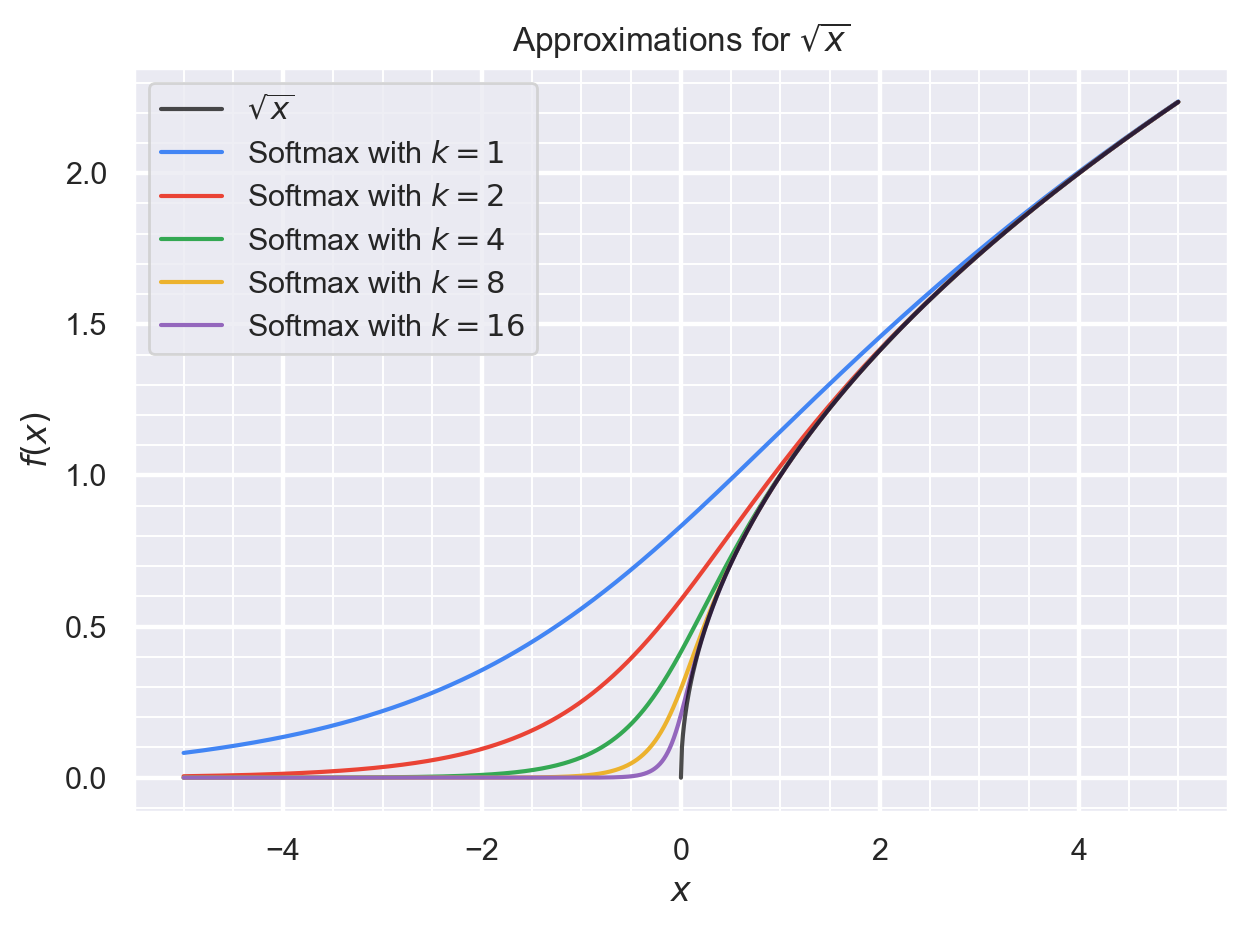

In [3]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
x = np.linspace(-5, 5, 1001)
plt.plot(x[x >= 0], np.sqrt(x[x >= 0]), "k", label=r"$\sqrt{x}$", zorder=4, alpha=0.7)
for k in [1, 2, 4, 8, 16]:
    plt.plot(x, np.softmax(0, x, hardness=k) ** 0.5, label=fr"Softmax with $k = {k}$")
p.show_plot(
    r"Approximations for $\sqrt{x}$",
    r"$x$",
    r"$f(x)$",
)

So for any positive value of hardness $k$, we can get an arbitrarily accurate approximation of $\sqrt x$ that has finite gradients everywhere. We could swap this into our optimization problem and things would solve just fine (provided we keep our $x > 0$ constraint to keep the problem bounded).

Let's look at another example.

## Constrained Minimization of $x ^ {1.5}$

Instead of minimizing $\sqrt x$, let's minimize $x ^ {1.5}$. This function has a derivative that approaches zero in the $x \rightarrow 0$ limit. Let's see what happens:

In [6]:
opti = asb.Opti()

x = opti.variable(init_guess=1, lower_bound=0)

opti.minimize(x ** 1.5)

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 0.00e+00 2.50e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

This solves - nice! However, note that posing the problem in this way is not guaranteed to work. This is because the underlying optimizer, IPOPT, does something it calls "bounds pushing". This is detailed in the excellent original IPOPT paper by Andreas Waechter, but the basic idea is that IPOPT solver performance seems to improve if the feasible space is extended by a small amount ($\epsilon \approx 10^{-8}$). In cases like this, that has the potential to allow a function like $x^{1.5}$ bounded by $x>0$ to go very slightly negative and NaN. IPOPT has lots of tools to help get the iterate back into the well-posed design space, but just be aware of this possibility.

Better practice would be to set the lower bound to something small but positive and nonzero, like $x>10^{-6}$. This ensures the underlying model will not NaN, even when the optimizer pushes the bounds a bit.